# Cutout Factory

* DP0.2
* data.lsst.cloud
* Weekly 2025_17
* Thu Jun 5 2025

For when an image is in-hand, and many cutouts from it are wanted.

In [1]:
import lsst.afw.display as afw_display
from lsst.daf.butler import Butler
import lsst.geom as geom
import matplotlib.pyplot as plt

afw_display.setDefaultBackend('matplotlib')

In [2]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')
dataId = {'visit': 192350, 'detector': 175, 'band': 'i'}
calexp = butler.get('calexp', **dataId)

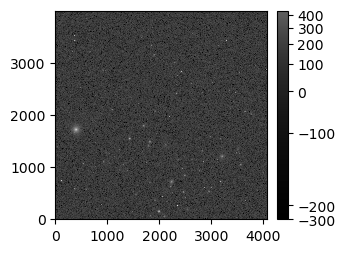

In [3]:
fig = plt.figure(figsize=(3,3))
display = afw_display.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image)
plt.show()

In [4]:
cutoutSize = geom.ExtentI(301, 301)

xy1 = geom.PointI(2250, 700)
bbox1 = geom.BoxI(xy1 - cutoutSize // 2, cutoutSize)

xy2 = geom.PointI(400, 1750)
bbox2 = geom.BoxI(xy2 - cutoutSize // 2, cutoutSize)

In [5]:
cutout1 = calexp.Factory(calexp, bbox1)
cutout2 = calexp.Factory(calexp, bbox2)

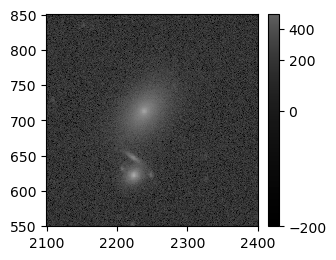

In [6]:
fig = plt.figure(figsize=(3, 3))
display = afw_display.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout1.image)
plt.show()

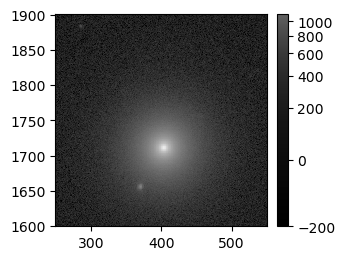

In [7]:
fig = plt.figure(figsize=(3, 3))
display = afw_display.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout2.image)
plt.show()